# Проект 09. Проведение А/В тестирования и анализ его результатов .

Проект заказан крупным интернет-магазином. Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки. 

##### Необходимо приоритизировать гипотезы, провести A/B-тест и проанализировать его результаты.
 
В файле hypothesis.csv записаны данные о 9 гипотезах по увеличению выручки интернет-магазина.       
Датасет содержит следующие поля:       
    • Hypothesis — краткое описание гипотезы;        
    • Reach — охват пользователей по 10-балльной шкале;       
    • Impact — влияние на пользователей по 10-балльной шкале;        
    • Confidence — уверенность в гипотезе по 10-балльной шкале;         
    • Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 

Результатаы, полученные при проведении A/B-теста описаны в файлах orders.csv и visitors.csv.     
Датасет orders.csv с информацией о заказах содержит следующие поля:       
    • transactionId — идентификатор заказа;       
    • visitorId — идентификатор пользователя, совершившего заказ;       
    • date — дата, когда был совершён заказ;       
    • revenue — выручка заказа;
    • group — группа A/B-теста, в которую попал заказ.       
Датасет visitors.csv с информацией о количестве пользователей сайта содержит следующие поля:        
    • date — дата;     
    • group — группа A/B-теста;      
    • visitors — количество пользователей в указанную дату в указанной группе A/B-теста.


### Оглавление:

#### Шаг 1. Загрузка и предобработка данных для анализа

#### Шаг 2. Приоритизация гипотез:
#####            •	Применить фреймворк ICE для приоритизации
#####            •	Применить фреймворк RICE  
#####            •	Проанализировать различия  

#### Шаг 3. Анализ A/B-теста:
#####            •  Анализ выручки по группам
#####            •  Анализ среднего чека
#####            •  Анализ среднего количества заказов 
#####            •  Анализ стоимости заказов 
#####            •  Расчет статистической значимости различий

#### Шаг 4. Обоснование решения по результатам теста
    

## Шаг 1. Загрузка и предобработка данных для анализа

Импортируем библиотеки, которые по всей видимости будут нужны 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt

В соответствии с описанием проекта весь имеющийся у нас набор данных распределен по трем датасетам:       
hypothesis.csv хранит данные о 9 гипотезах по увеличению выручки интернет-магазина        
orders.csv — информацию о заказах,          
visitors.csv  — информацию с количеством пользователей сайта по дням.

Прочтем последовательно все три исходных файла с данными     
(try...except для того, чтобы можно было читать файл не только локально, но и из общего хранилища). 

In [12]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
    
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders_ini = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

Посмотрим общую информацию о имеющихся в нашем распоряжении датафреймах:           
сколько строк в столбцах, много ли пропусков и в каких столбцах, какие у данных типы и насколько это совпадатет с сутью cамих данных.           
А так-же взглянем как выглядят "голова" и "хвост" датафреймов.

Сначала посмотрим на датафрейм с данными о гипотезах - hypothesis:

In [13]:
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [14]:
pd.set_option('display.max_colwidth', False)

hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


##### Видим:

В принципе этот пункт делается для "методологического порядка" поскольку по условиям проекта гипотезы формировались (и записывалисть в датасет) при нашем учатстии и значит "неожиданностей" юыть не должно.

##### Итак:
1. В датасете 5 столбцов, что совпадает с описанием проекта:                 
    • Hypothesis — краткое описание гипотезы;
    • Reach — охват пользователей по 10-балльной шкале;
    • Impact — влияние на пользователей по 10-балльной шкале;
    • Confidence — уверенность в гипотезе по 10-балльной шкале;
    • Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 
      Чем больше значение Efforts, тем дороже проверка гипотезы. 
      
2. Типы столбцов соответствуют их природе: формулировка гипотезы - это символьная строка (тип object, остальные столбцы        имеют тип int64, поскольку в них записаны оценки по 10-ти бальной шкале соответствующих параметров гипотезы для            фреймфорков ICE и RICE.

3. Датафрейм содержит 9 строк - по количеству сформулированных гипотез в соответстсвии с описанием.            
              
4. Поскольку и строк и столбцов немного - сразу видно, что пропусков и дубликатов в датасете нет (даже если забыть, что мы его сами же и формировали).

5. Единственное, что наверное есть смысл сделать в этом датафрейме с точки зрения предобработки - это привести названия столбцов к нижнему регистру.

In [15]:
# преобразуем столбцы
hypothesis.columns = hypothesis.columns.str.lower()

# смотрим что получилось
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Наименования столбцов этого датасета теперь в нижнем регистре

Теперь посмотрим на датасет с данными о покупках - orders_ini:

In [16]:
orders.info()
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


##### Видим:

1. В полном соответствии с описанием в датасете 5 столбцов:                 
    • transactionId — идентификатор заказа;       
    • visitorId — идентификатор пользователя, совершившего заказ;        
    • date — дата, когда был совершён заказ;        
    • revenue — выручка заказа;       
    • group — группа A/B-теста, в которую попал заказ.
    
2. В типах столбцов есть два столбца, которые вызывают вопросы:    
    • столбец date имеет тип object, то есть строчное "описание словами" даты заказа. По всей видимости нужно перевести в         тип datetime;       
    • столбец revenue имеет тип int64. Оставим этот столбец как есть - будем предполагать, что ценовая политика интернет-         магазина такова, что все цены выражены целым количеством рублей. Это предположение видится достаточно правдоподобным,       хотя в реальной практике не лишне было бы убедится в этом впрямую.

3. Датафрейм содержит 1197 строк (нечетное количество и цифра не очень "ровная"). Хорошо бы сразу убедиться, что разделены они примерно поровну между группами А и В.            
              
4. На взгляд пропусков и убликатов нет, но нужно бы убедиться в этом непосредственно.

5. Хорошо бы привести названия столбцов к "питоновскому стилю".

Начнем с конца - переименуем столбцы:

In [17]:
# переименовуем столбцы
orders.rename(columns= {'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, inplace=True )

# смотрим что получилось
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Наименования столбцов выглядят правильно.

Теперь изменим тип данных для столбца 'date'

In [18]:
# преобразуем к типу datetime и оставим только дату
orders['date'] = pd.to_datetime(orders['date']).dt.normalize()

# смотрим что получилось
display(orders['date'].dtype)
orders.head(1)

dtype('<M8[ns]')

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B


Типы данных в порядке.

Посмотрим есть ли пропуски в данных

In [19]:
orders.isna().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

Пропусков нет.

Посмотрим есть ли дубликаты

In [20]:
orders.duplicated().sum()

0

Дубликатов тоже нет.

Посмотрим как распределены данные по группам А и В

In [21]:
print('A ', orders[orders['group'] == 'A'].value_counts().sum(), sep=' ')
print('B ', orders[orders['group'] == 'B'].value_counts().sum(), sep=' ')

A  557
B  640


Суммарное количество заказов групп А и В 557+640=1197, что совпадает с полным количеством строк в датафрейме. Значит никаких "посторонних" данных нет. При этом заказов в группе В ориентировочно на 15% больше, чем в группе А.

В завершение посмотрим на основные численные парметры этого датафрейма (фактически применительно только к датам и к колонке revenue.

In [22]:
orders.describe()

,transaction_id,visitor_id,date,revenue
count,1.197000e+03,1.197000e+03,1197,1.197000e+03
mean,2.155621e+09,2.165960e+09,2019-08-15 13:06:46.015037696,8.348006e+03
min,1.062393e+06,5.114589e+06,2019-08-01 00:00:00,5.000000e+01
25%,1.166776e+09,1.111826e+09,2019-08-08 00:00:00,1.220000e+03
50%,2.145194e+09,2.217985e+09,2019-08-15 00:00:00,2.978000e+03
75%,3.237740e+09,3.177606e+09,2019-08-23 00:00:00,8.290000e+03
max,4.293856e+09,4.283872e+09,2019-08-31 00:00:00,1.294500e+06
std,1.229085e+09,1.236014e+09,NaN,3.919113e+04


##### Можно отметить, два момента:

1. В соответствии с данными этого датасета тестирование проводилось в период с 1-го по 31-е августа 2019 года. Нужно будет сопоставить эти даты с датами из датасета visitors.

2. В колонке revenue видно, что:
   • данные есть за каждую покупку,
   • среднее в 2.5 раза больше медианы. Возможно есть выбросы в сторонц больших сумм,
   • минимальное значение сильно отличается и от медианы и даже от первого квартиля. По всей видимости есть выбросы так-же      в нижней части (маленькие, возможно тестовые суммы).

На всякий случай проверим количество дней теста, отраженных в этом датасете.

In [23]:
orders['date'].nunique()

31

Данные о покупках есть за все 31 день тестирования в Августе 2019 года.

Таким образом с датасетом orders всё в порядке.

Теперь посмотрим на датасет с данными о количестве пользователей - visitors

In [24]:
visitors.info()
visitors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


##### Видим:

1. Как и дано в описании датафрейм visitors имеет 3 столбца:                 
    • date — дата теста;       
    • group — группа теста;        
    • visitors — количество пользователей в указанную дату в указанной группе.
    
2. По типам столбцов только столбец date имеет тип object, то есть по всей видимости нужно перевести его в тип datetime.

3. Датафрейм содержит 62 строки. На взгляд такое количество дней для проведения А/В теста видится репрезентативным.  
   В этом случае так-же неплохо было бы убедиться, что пользователи разделены примерно поровну между группами А и В.          Кроме того хорошо бы убедиться, что за каждую дату есть данные и по группе А и по группе В          
              
4. На взгляд пропусков и убликатов нет, но нужно бы убедиться в этом непосредственно.

5. И хорошо бы проверить, что диапазон дат проведения тестов в датафрейме visitors совпадает с диапазоном в датафрейме orders.

##### Можно отметить, что:

1. В соответствии с данными и этого датасета тестирование так-же проводилось в период с 1-го по 31-е августа 2019 года. Эти даты совпадают с датами из датасета orders.

2. В колонке visitors видно, что:     
   • данные о количестве посетителей есть за каждую дату тестов,       
   • среднее количество посетителей ниже медианы. Кроме того минимально значение сильно отличается и от медианы и даже от первого квартиля. Вполне возможно причина этому выбросы в сторону дней с относительно небольшой посещаемостью.

##### Итак:

Провели предобработку датафреймов, которые в дальнейшем будем исследовать, 
проверили соответствие данных в различных датафреймах друг другу,    
отметили основные особенности данных, которые заметны на данном этапе,    
критических проблем или несоответствий не выявлено.

В результате считаем, что предобработка успешно завершена и можно переходить  к приоритезации гипотез и анализу результатов А/В тестирования.

Изменим тип данных для столбца 'date' на datetime

In [25]:
# преобразуем к типу datetime и оставим только дату
visitors['date'] = pd.to_datetime(visitors['date']).dt.normalize()

# смотрим что получилось
display(visitors['date'].dtype)
visitors.head(1)

dtype('<M8[ns]')

,date,group,visitors
0,2019-08-01,A,719


Типы данных в порядке.

Посмотрим есть ли пропуски в данных

In [26]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

Пропусков нет.

Посмотрим есть ли дубликаты

## Шаг 2. Приоритизация гипотез.

Работать будем с датафреймом hypothesis.

In [30]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


## Шаг 3. Анализ A/B-теста.

Предполагается, что мы провели A/B-тест и получили результаты, которые описаны в файлах orders.csv и visitors.csv.         
Необходимо проанализировать результаты проведеного A/B-теста.

Поскольку большая часть анализа будет основываться накумулятивных данных сделаем предварительную их подготовку

### Подготовка кумулятивных данных.

Для начала вспомним датафреймы orders и visitors.

In [35]:
display(orders.head())
display(visitors.head())

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Создадим новый датафрейм cumulative_data, в который включим следующие столбцы:        
•	date — дата;              
•	group — группа A/B-теста (A или B);                     
•	orders — кумулятивное количество заказов на указанную дату в указанной группе;                       
•	buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;   
•	revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);         
•	visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

В качестве основы создаем массив уникальных пар значений дат и групп.

In [36]:
# создаем датафрейм
dates_groups = orders[['date','group']].drop_duplicates()

# смотрим что получилось
dates_groups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Получим агрегированные кумулятивные данные о заказах и посетителях по дням

In [37]:
# получаем агрегированные кумулятивные данные о заказах
orders_aggregated = dates_groups \
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])] \
                    .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1) \
                    .sort_values(by=['date','group'])

# аналогично получаем агрегированные кумулятивные данные о посетителях 
visitors_aggregated = dates_groups \
                    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])] \
                    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1) \
                    .sort_values(by=['date','group'])

# смотрим что получилось
display(orders_aggregated.head())
display(visitors_aggregated.head())

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим полученные агрегированные кумулятивные данные о заказах и посетителях и сформируем наш результирующий датафрейм

In [38]:
# объединяем данные
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])

# присваиваем ее столбцам понятные названия
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# выводим результат
display(cumulative_data.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


##### Датафрейм с кумулятивными данными создан.          
На его основе можно формировать отдельные срезы данных для определенных метрик, строить графики и проводить анализ.

### 2.	Анализ кумулятивного среднего чека по группам А и В.

Чтобы получить кумулятивный средний чек нужно разделить кумулятивную выручку на кумулятивное число заказов.

In [45]:
# вычисляем кумулятивный средний чек для групп А и В
cum_rev_per_order_a = cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders']
cum_rev_per_order_b = cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders']

# смотрим что получилось
display(cum_rev_per_order_a.head())
#display(cum_rev_per_order_b.head())

0    6190.791667
2    5509.113636
4    5218.735294
6    5067.845238
8    5045.110092
dtype: float64

Построим графики кумулятивного среднего чека по дням для групп A и B.

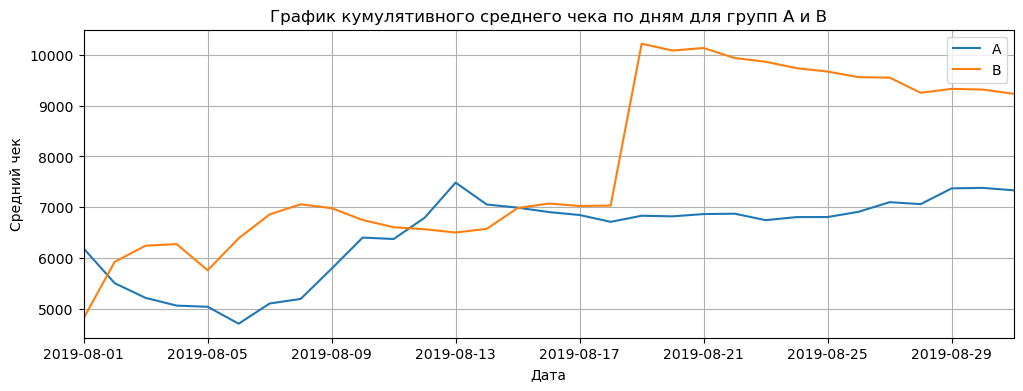

In [47]:
# задаем рамку графика
plt.figure(figsize=(12,4))

# строим график для группы А
plt.plot(cumulative_revenue_a['date'], cum_rev_per_order_a, label='A')

# строим график для группы B
plt.plot(cumulative_revenue_b['date'], cum_rev_per_order_b, label='B')

# задаем параметры графика
plt.grid(True)
plt.xlim(dt.datetime.strptime("2019-08-01", '%Y-%m-%d'), dt.datetime.strptime("2019-08-31", '%Y-%m-%d'))
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend() 
plt.title('График кумулятивного среднего чека по дням для групп A и B')

# выводим результат
plt.show()

##### Видим:

В целом поведение среднего чека несколко более волатильно, нежели поведение кумулятивной выручки:  

    • с 1.08 по 5-6.08 средние чеки в группах ведут себя противофазно: средний чек в группе А падает с примерно 6200 до 4700, в то время как в группе В средний чек растет с тех же 4800 до 6200,          
    • с 6.08 по 9.08 средний чек синхронно растет в обеих группах примерно одинаковыми темпами,         
    • с 9.08 по 13.08 средний чек в группе В начинает стагнировать и даже снижается, в то время как в группе А он продолжает рост,      
    • с 13.08 по 18.08 графики в общем выравниваются и стабилизируются (выходят на плато),        
    • 18-19 августа, как мы уже отмечали анализируя график кумулятивной выручки, в группе В наблюдается большой всплеск как по выручке, так и по среднему чеку,               
    • с 20.08 и до завершения теста 31.08 средняя выручка в целом продолжает стагнировать в обеих группах, в группе А слегка возрастая, а в группе В несколько снижаясь. При этом существенная разница значений среднего чека, образовавшаяся 18-19 числа сохраняется до конца теста.

Таким образом наше предположение о крупных покупках в группе В в период 18-19 августа по всей видимости подтверждается.    
А с учетом куда более "синхронного" поведения графиков для групп А и В на других временных учатсках - можно рассматривать эти крупные покупки как нехарактерное поведение (выбросы) и для корректной формулировки выводов исключить их из рассмотрения.

### 3.	Анализ относительного изменения кумулятивного среднего чека группы B к группе A.

Чтобы получить значение относительного изменения кумулятивного среднего чека для группы B к группе A нужно разделить один средний чек на другой и вычесть из полученного частного единицу.

Перед тем как строить график объединим данные из cumulative_revenue_a и cumulative_revenue_b по дате чтобы иметь единый массив с датами и значениями для графика.

In [48]:
# объединяем данные по дате
merged_cumulative_revenues = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', \
                                                       how='left', suffixes=['A', 'B'])

# смотрим что получилось
merged_cumulative_revenues.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


Теперь построим график относительного изменения кумулятивного среднего чека группы B к группе A.   
И для наглядности добавим на график горизонтальные оси на уровне y = 0 и y = 0.25.

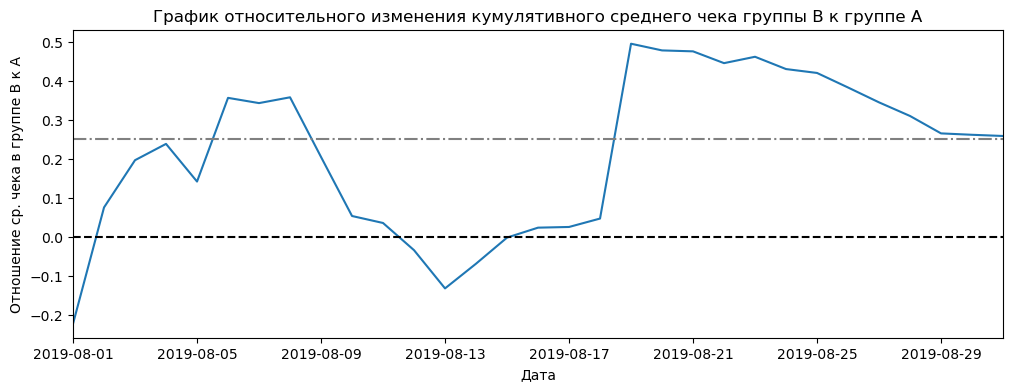

In [51]:
# задаем рамку графика
plt.figure(figsize=(12,4))

# вычисляем отношение средних чеков и наносим на график
plt.plot(merged_cumulative_revenues['date'], \
         (merged_cumulative_revenues['revenueB']/merged_cumulative_revenues['ordersB'])/ \
         (merged_cumulative_revenues['revenueA']/merged_cumulative_revenues['ordersA'])-1)

# добавляем ось y = 0
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.25, color='grey', linestyle='-.')

# задаем параметры графика
plt.xlim(dt.datetime.strptime("2019-08-01", '%Y-%m-%d'), dt.datetime.strptime("2019-08-31", '%Y-%m-%d'))
plt.xlabel('Дата')
plt.ylabel('Отношение ср. чека в группе В к А')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')

# выводим результат
plt.show()


##### Видим:

В целом график относительного изменения кумулятивного среднего чека группы B к группе A повторяет поведение среднего чека в части волатильности и разбивки на периоды:  
    • с 1.08 по 5.08 график растет от -0.2 до +0.25,
    • 5-6.08 слегка падает,
    • с 6.08 по 9.08 вновь растет до 0.35,
    • с 9.08 по 13.08 довольно существенно снижается до -0.15,      
    • с 13.08 по 18.08 вновь растет до +0.05,        
    • 18-19 августа, здесь (как и на предыдущих графиках) наблюдается резкий всплеск с 0.05 до аж 0.5,               
    • с 20.08 и до завершения теста 31.08 наблюдается снижение с 0.5 до 0.25 в последние дни "прижимаясь" к этому уровню и по         всей видимости начиная стагнировать.           
По всей видимости такие резкие скачки графика (как минимум 18-19 августа) - это еще одно свидетельство каких-то аномально крупных заказов. Нужно будет учитывать их в дальнейшем анализе.          
Поведение графика на финальном отрезке позволяет надеяться, что средний чек в группе В может оказаться на 20-25% выше, чем в группе А. Однако уверенности в этом нет, нужно будет смотреть, что покажут тесты на статистическую значимость.    
Поскольку тренд все-таки к снижению  - вполне возможно, что для четкого подтверждения этого понадобится продолжение тестирования и после окончания августа 2019 года.

### 4.	Анализ кумулятивного среднего количества заказов на одного посетителя по группам А и В.

Чтобы получить значение кумулятивного среднего количества заказов на посетителя нужно кумулятивное количество заказов (столбец orders в нашем датафрейме cumulative_data) разделить на кумулятивное количество посетителей (столбец visitors в этом же датафрейме).

Перед тем как строить график посчитаем этот параметр и разделим его по группам А и В.

In [52]:
# считаем среднее количество заказов на посетителя и добавляем отдельным столбцом в тот же фрейм
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# смотрим что получилось
display(cumulative_data_a.head())
#display(cumulative_data_b.head())

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
2,2019-08-02,A,44,38,242401,1338,0.032885
4,2019-08-03,A,68,62,354874,1845,0.036856
6,2019-08-04,A,84,77,425699,2562,0.032787
8,2019-08-05,A,109,100,549917,3318,0.032851


Теперь построим график среднего количества заказов на посетителя по группам А и В.

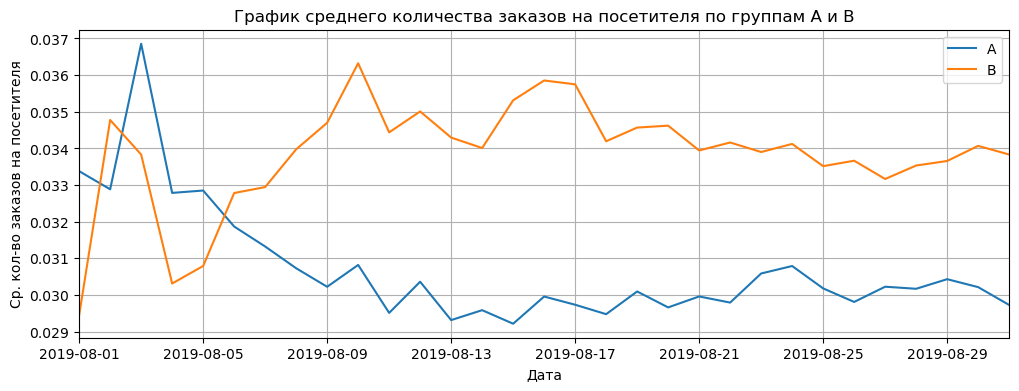

In [54]:
# задаем рамку графика
plt.figure(figsize=(12,4))

# строим график для группы А
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')

# строим график для группы B
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

# задаем параметры графика
plt.grid(True)
plt.xlim(dt.datetime.strptime("2019-08-01", '%Y-%m-%d'), dt.datetime.strptime("2019-08-31", '%Y-%m-%d'))
plt.xlabel('Дата')
plt.ylabel('Ср. кол-во заказов на посетителя')
plt.legend() 
plt.title('График среднего количества заказов на посетителя по группам А и В')

# выводим результат
plt.show()

##### Видим:

График довольно четко бьется на три периода:

После начального довольно короткого периода (с 01.08 по 05.08) волатильности (с размахом значений от 0.030 до 0.037 заказов на посетителя),          
наступает (с 05.08 по 10.08) период роста в группе В (с 0.031 до 0.036) и одновременно симметричного падения в группе А (с 0.033 до 0.030)        
и затем наступает период относительной стабильности (с 10.08 до окончания теста 31.08), когда       
    в группе В среднее количество покупок на пользователя колеблется в пределах значений от 0.033 до 0.035 (с буквально одним превышением до 0.036 16-го августа),         
    а в группе А этот показатель колеблется 0.030 +- менее 0.001.
    
Таким образом         
• по всей видимости, в стабилизировавшемся" состоянии среднее количество покупок на одного пользователя где-то на 13-15% больше.                
• по всей видимости выбросы, которые мы наблюдали на графиках выручки в районе 18-19 августа не связаны с количеством покупок на клиента и полностью объясняются величиной этих самых "нетипичных" покупок.

### 5.	Анализ относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

Чтобы получить значение относительного изменения кумулятивного среднего количества заказов на посетителя для группы B к группе A нужно разделить значение среднего количества заказов на посетителя для группы В на аналогичное значение для группы А и вычесть из полученного частного единицу.

Перед тем как строить график объединим данные из cumulative_data_a и cumulative_data_b по дате чтобы иметь единый массив с датами и значениями для графика.

In [55]:
# объединяем данные по дате
merged_cumulative_conversions = cumulative_data_a[['date','conversion']] \
                                .merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', \
                                                         how='left', suffixes=['A', 'B'])

# смотрим что получилось
merged_cumulative_conversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


Теперь построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.   
И для наглядности добавим на график горизонтальные оси на уровне y = 0 и y = 0.15.

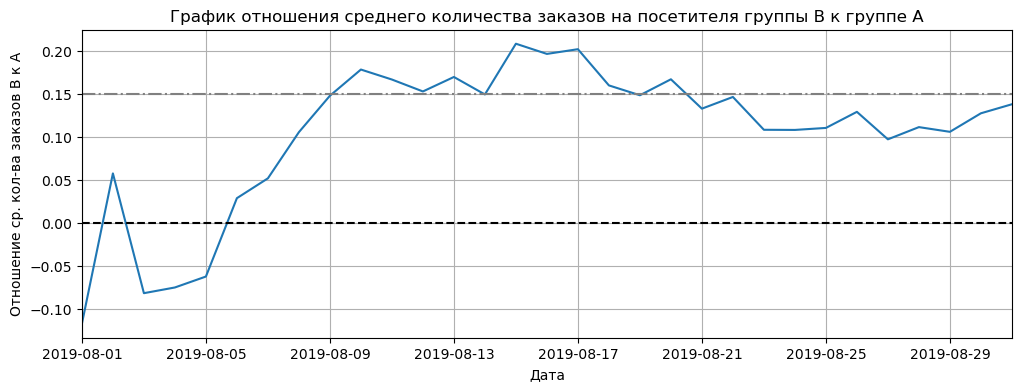

In [56]:
# задаем рамку графика
plt.figure(figsize=(12,4))

# вычисляем отношение средних чеков и наносим на график
plt.plot(merged_cumulative_conversions['date'], \
         (merged_cumulative_conversions['conversionB']/ \
         merged_cumulative_conversions['conversionA'] - 1)
        )

# добавляем ось y = 0
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='-.')

# задаем параметры графика
plt.grid(True)
plt.xlim(dt.datetime.strptime("2019-08-01", '%Y-%m-%d'), dt.datetime.strptime("2019-08-31", '%Y-%m-%d'))
plt.xlabel('Дата')
plt.ylabel('Отношение ср. кол-ва заказов В к А')
plt.title('График отношения среднего количества заказов на посетителя группы B к группе A')

# выводим результат
plt.show()


##### Видим:

После начального периода (с 01.08 по 05.08) волатильности когда группа В в основном "проигрывала" группе А,          
наступает (с 05.08 по 10.08) период роста относительного среднего количества заказов на пользователя в группе В (с -0.07 до +0.17),        
после чего (с 10.08 до окончания теста 31.08) показатель стабилизируется на уровне +0.15 +-0.05.
    
Таким образом         
• судя по всему отношение среднего количества заказов на посетителя ещё окончательно не установилось, поскольку в финальном периоде (последние 4-5 дней теста) мы все-таки наблюдаем рост показателя. Поскольку  на финальном участке наблюдается рост, вполне возможно, что для его оценки понадобится продолжить тестирование (если такая возможность есть);     
• однако по всей видимости, мы все-таки можем подтвердить наши выводы из предыдущего пункта: похоже, что среднее количеств заказов на посетителя в группе В на 13-15% больше, чем в группе А.      
При этом разница не опускалась ниже уровня +10% с 08.08.2019 и тенденции к уменьшению указанной разницы в последнюю неделю тестирования не наблюдается.

### 6.	Анализ с использованием точечной диаграммы количества заказов по пользователям, совершившим заказ.

Выделять заказы и рассчитывать их количество по пользователям будем на основании датафрейма orders.      
Для начала вспомним как он выглядит.

In [57]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Чтобы рассчитать количество заказов по пользователям нам нужно будет сгруппировать датафрейм по столбцу visitor_id и для каждого такого visitor_id посчитать количество уникальных значений в столбце transaction_id.

In [58]:
# группируем датафрейм по visitor_id и берем количество уникальных transaction_id 
orders_by_users = (
    orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
                  )

orders_by_users.columns = ['user_id', 'orders']

print(orders_by_users.sort_values(by='orders', ascending=False).head(15))

         user_id  orders
1023  4256040402  11    
591   2458001652  11    
569   2378935119  9     
487   2038680547  8     
44    199603092   5     
744   3062433592  5     
55    237748145   5     
917   3803269165  5     
299   1230306981  5     
897   3717692402  5     
393   1614305549  4     
114   457167155   4     
619   2587333274  4     
340   1404934699  3     
937   3908431265  3     


##### Видим:

Если "нижнюю" часть вывода, где фигурируют пользователи с тремя заказами можно считать вполне нормальной и обычной с точки зрения логики "среднестатистического" потребителя,       
то верхняя часть, где фигурируют 8, 9 и даже 11 заказов - это явно нетипично и не массово (больше, чем обычный пользователь совершает в неделю не может быть нормой).     
Случаев такого большого количества заказов дейтсвительно немного, но они есть и по всей видимости влияют на статистические параметры и могут искажать резуьтаты тестов.

Чтобы лучше увидеть распределение количества заказов на одного пользователя построим точечную диаграмму этого распределения.

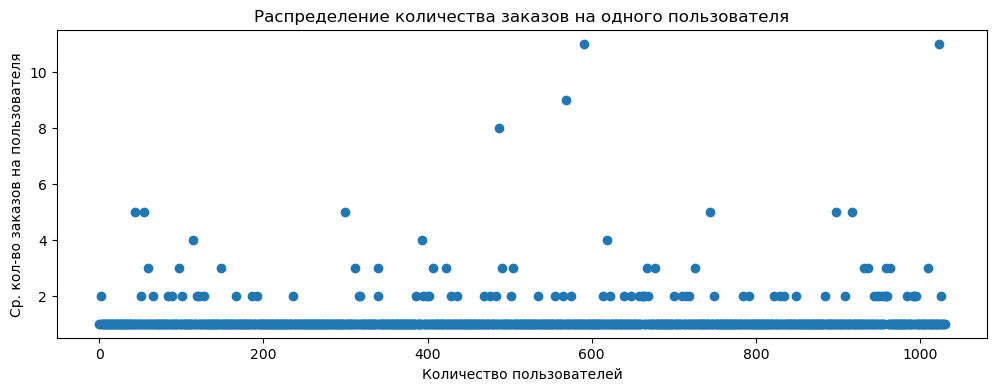

In [60]:
# задаем параметр для оси х по количеству пользователей в orders_by_users
x_values = pd.Series(range(0,len(orders_by_users)))

# задаем рамку графика
plt.figure(figsize=(12,4))

# задаем точечную диаграмму
plt.scatter(x_values, orders_by_users['orders']) 

# задаем параметры графика
plt.xlabel('Количество пользователей')
plt.ylabel('Ср. кол-во заказов на пользователя')
plt.title('Распределение количества заказов на одного пользователя')

# выводим результат
plt.show()

##### Видим:

• подавляющее большинство выборки составляют пользователи, сделавшие 1 или 2 заказа;             
• три заказа на пользователя так-же можно считать достаточно распространенным ( их 17 в выборке);       
• пользователей, сделавших 4 и 5 заказов уже существенно меньше ( 3 и 6 случаев), однако относить их к случайностям или нет - не ясно (все-таки суммарно их всего в 2 раза меньше, чем пользователей с тремя заказами);          
• случаи с 6-ю и более заказов на одного пользователя - это случаи единичные и их общее количество минимально ( 4 на выборку). Думается, что такие случаи точно можно отнести к "выбросам".

### 7.	Расчет 95-й и 99-й перцентили количества заказов на пользователя и выбор границы аномальных пользователей.

Посчитаем выборочные перцентили количества заказов на одного пользователя при помощи функции np.percentile():

In [61]:
print(np.percentile(orders_by_users['orders'], [95, 97.5, 99])) 

[2. 3. 4.]


##### Получается, что:          
• не более 5% пользователей оформили более 2-х заказов;    
• только 1% пользователей оформил более 4-х заказов (5 и более).   

В принципе можно было бы определить 3 заказа как верхнюю границу,        
однако более резонным все-таки видится принять в качестве верхней границы количество заказов раное 4.      
Это даст перцентиль на уровне 97.5% то есть отсеет 2.5% пользователей, что будет хорошим компромисом между полнотой картины и точностью оценок. 

### 8.	Анализ стоимостей заказов при помощи точечной диаграммы .

Стоимости заказов находятся в колонке revenue датафрейма orders.      
Отсортируем датафрейм orders по убяванию значений в столбце revenue и посмотрим

In [62]:
orders.sort_values('revenue', ascending=False).head(15)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


##### Видим:

Как и в случае с количеством заказов "нижняя" часть вывода по всей видимости представляет собой "типичную массу": величина чека здесь распределена довольно ровно и отлиичя соседник позиций незначительны (2-5%).      
Однако как минимум первые две строки кратно (в разы) отличаются даже от "ближайших преследователей", которые и сами по себе являются величинами большими и в свою очередь почти вдвое превосходят представителей 10-15 мест. Такие величины стоимоти заказов никак не могут рассматриваться как типичные и наверняка являются выбросами.

Чтобы лучше увидеть распределение стоимости заказов построим точечную диаграмму этого распределения.

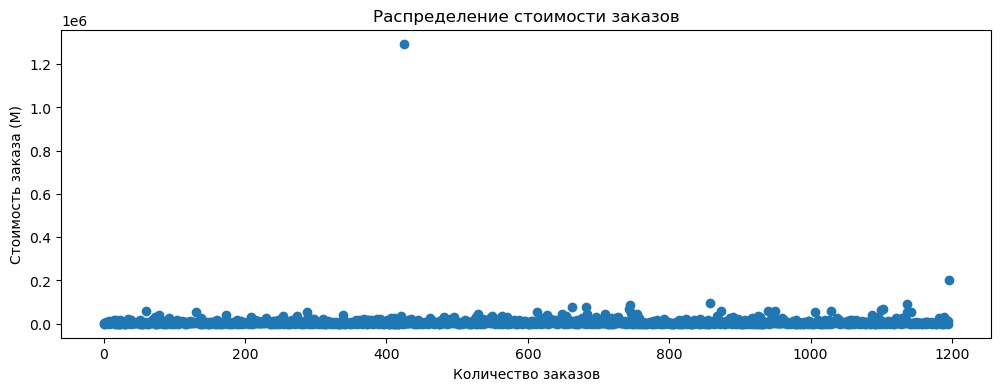

In [63]:
# задаем параметр для оси х по количеству пользователей в orders
x_values = pd.Series(range(0,len(orders['revenue'])))

# задаем рамку графика
plt.figure(figsize=(12,4))

# задаем точечную диаграмму
plt.scatter(x_values, orders['revenue']) 

# задаем параметры графика
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказа (M)')
plt.title('Распределение стоимости заказов')

# выводим результат
plt.show()

Пока видно только то, что за счет одногонеобычайно большого выброса в стоимости заказа весь масштаб диаграммы "сдвинулся вверх" и более-менее детально увидеть распределение в "околонулевой" области, где и находятся практически все точки распределения - практически невозможно.      
Видно только, что основная масса точек в области меньше 100 тысяч, есть возможно несколько выбросов больше 100 тысяч и буквально один выброс около 200 тысяч.

Попробуем ввести ограничение сверху на масштаб по оси y в 100-120 тысяч и рассмотреть повнимательнее "нижнюю" часть.

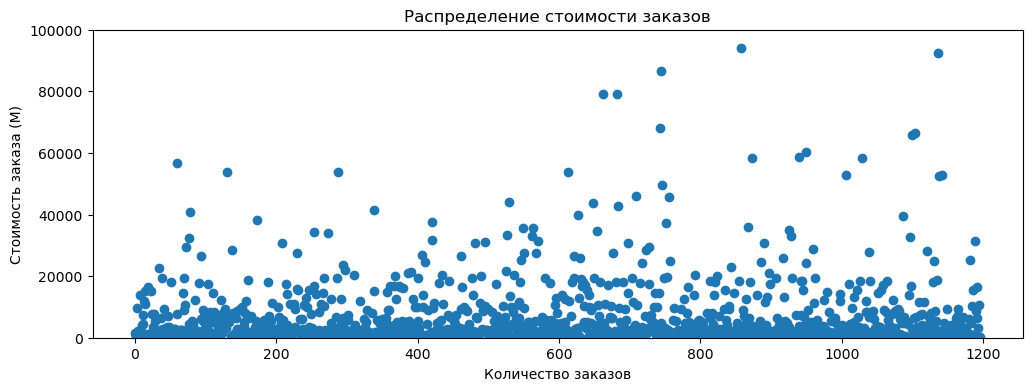

In [64]:
# задаем параметр для оси х по количеству пользователей в orders
x_values = pd.Series(range(0,len(orders['revenue'])))

# задаем рамку графика
plt.figure(figsize=(12,4))

# задаем точечную диаграмму
plt.scatter(x_values, orders['revenue']) 

# задаем параметры графика
plt.ylim(0,100000)
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказа (M)')
plt.title('Распределение стоимости заказов')

# выводим результат
plt.show()

##### Видим:

• подавляющее большинство выборки составляют суммы, меньше 25 тысяч рублей;             
• суммы от 25 до 40 тысяч составляют хоть и меньшую, но значимую часть выборки;       
• суммы от 40 до 60 тысяч видятся редкими, но наверное не единичными случаями;          
• и наконец суммы выше 60 тысяч являются явно единичными. Общее их количество по всей видимости составляет 12-15 штук.     
Думается, что такие случаи точно можно отнести к "выбросам".

### 9.	Расчет 95-й и 99-й перцентили стоимости заказов и выбор границы аномальных сумм заказов .

Посчитаем выборочные перцентили стоимости заказов при помощи функции np.percentile():

In [65]:
print(np.percentile(orders['revenue'], [95, 97.5, 99])) 

[28000.  39530.  58233.2]


##### Получается, что:          
• не более 5% заказов имеют чек выше 28 тысяч рублей;    
• только 1% заказов дороже 58 с четвертью тысяч.   

Исходя из тех же соображений, которые мы высказывали при определении границы по количеству заказов (брать некую среднюю границу между  95% и 99% - где-то на уровне около 97.5%) наиболее взвешенным видится  выбор суммы в 40 тысяч рублей за заказ.

### 10.	Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Попробуем простроить логику действий:
1. Чтобы посчитать статистическу значимость нужно по одному из статистических методов найти p-value предположения, что среднее количество заказов по группам равны.               
2. Поскольку как мы выяснили ранее в наших тестах есть довольно много выбросов с точки зрения количества заказов на пользователя и мы такие выбросы пока не отсекаем - то будем пользоваться методом mannwhitneyu().           
3. Чтобы получить корректный результат нам нужно предъявить в качестве аргументов метода массивы по группам А и В со значениями количества заказов на каждого посетителя сайта (не только не пользователя).          
4. Чтобы получить такие массивы нужно разбить датафрейм orders на группы А и В, по каждой группе посчитать количество заказов на пользователя и затем дополнить каждый из этих массивов нулями до полного количества посетителей по каждой группе.

Проделаем эти действия в обратном порядке.

На основе датафрейма orders создадим два отдельных датафрейма orders_by_users_a и orders_by_users_b со столбцами user_id и  user_id, аналогично тому, как мы делали чуть выше без разбивки на группы для построения точечной диаграммы.

In [66]:
# разбиваем датафрейм по группам, группируем по visitor_id и берем количество уникальных transaction_id 
orders_by_users_a = (
    orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
                  )
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
                  )
orders_by_users_b.columns = ['user_id', 'orders']

# смотрим что получилось
display(orders_by_users_a.sort_values(by='orders', ascending=False).head(3))
display(orders_by_users_b.head(3))

,user_id,orders
499,4256040402,7
227,2038680547,5
278,2458001652,5


,user_id,orders
0,5114589,1
1,6958315,1
2,8300375,1


Для дальнейших действий из полученных датафреймов нам понадобятся столбцы orders.      
Однако их нужно дополнить нулями таким образом, чтобы суммарное количесво записей в столбцах было равно общему количеству посетителей для каждой группы.

Общее количество посетителей в каждой группе можно узнать разделив датафрейм visitors на группы А и В и просуммировав столбец visitors по дням.       
Для удобства пока не будем агрегировать по дням. 

In [67]:
# выделяем посетителей из группы А
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]

# выделяем посетителей из группы В
visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]

# смотрим что получилось
display(visitors_daily_a.head())
display(visitors_daily_b.head())

,date,visitors
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


,date,visitors
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


Создадим объект pd.Series для "дополнения" нулями. Его длина например для группы А должна составлять: сумма по колонке visitors датафрейма visitors_daily_a минус длина столбца order датафрейма orders_by_users_a, который мы сформировали чуть выше. Длину зададим методом np.arange()

In [68]:
# формируем серию для группы А
zero_add_a = pd.Series(0, index=np.arange(visitors_daily_a['visitors'].sum() \
                                          - len(orders_by_users_a['orders'])), name='orders')

# формируем серию для группы B
zero_add_b = pd.Series(0, index=np.arange(visitors_daily_b['visitors'].sum() \
                                          - len(orders_by_users_b['orders'])), name='orders')
                       

# смотрим что получилось
display(zero_add_a.head())
display(zero_add_b.tail())

0    0
1    0
2    0
3    0
4    0
Name: orders, dtype: int64

18325    0
18326    0
18327    0
18328    0
18329    0
Name: orders, dtype: int64

Теперь последовательно "склеим" столбец order датафрейма orders_by_users_* с созданной серией zero_add_* при помощи функции pd.concat() и получим выборки групп А и В для предъявления в качестве аргументов для статистического метода Манна-Уитни

In [69]:
# формируем выборку из "сырых" данных для группы А
sample_orders_a = pd.concat([orders_by_users_a['orders'], zero_add_a], axis=0) 

# формируем выборку из "сырых" данных для группы В
sample_orders_b = pd.concat([orders_by_users_b['orders'], zero_add_b], axis=0)

# смотрим что получилось
display(sample_orders_a.head(3))
display(sample_orders_b.tail(3))

0    1
1    1
2    1
Name: orders, dtype: int64

18327    0
18328    0
18329    0
Name: orders, dtype: int64

Ну и наконец применим статистический метод Манна-Уитни (mannwhitneyu()).    
Нулевая гипотеза - среднее количество заказов на посетителя, посчитанное на основе «сырых» данных для групп А и В равны;    
Альтернативная гипотеза - что они не равны.      
Уровень статистической значимости alpha возьмем равным 5%.      
Получим p-value и сравним с alpha:    
если p-value меньше или равна alpha - нулевую гипотезу о равенстве отвергнем в пользу альтернативной гипотезы,      
если же p-value больше alpha - нулевую гипотезу о равенстве не станем отвергать.

In [70]:
alpha = 0.05

results = stats.mannwhitneyu(sample_orders_a, sample_orders_b)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: различия между группами есть')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.016792355056752608
Отвергаем нулевую гипотезу: различия между группами есть


##### Таким образом:

По результатам оценки статистиеской значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным можем утверждать, 
• что различия в среднем количестве заказов между группами есть    
• и эти различия статистически значимы (причем не только для уровня 5% но и для уровня например 2%).

По всей видимости можно (пока с опасениями относительно влияния выбросов) подтвердить сделанное нами ранее предположение, что в группе В (вероятно экспериментальной) среднее количество заказов на посетителя на 13-15% больше, чем в контрольной группе А.

### 11.	Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

Рассчитать статистическую значимость для среднего чека несколько проще, чем для количества заказов на посетителя.   
Данные для подстановки в качестве аргументов в метод mannwhitneyu() в этом случае - это просто части столбца revenue датафрейма orders, отделенные по группам А и В. 

In [71]:
# формируем выборку из "сырых" данных для группы А
sample_revenue_a = orders[orders['group'] == 'A']['revenue'] 

# формируем выборку из "сырых" данных для группы В
sample_revenue_b = orders[orders['group'] == 'B']['revenue']

# смотрим что получилось
display(sample_revenue_a.head(3))
display(sample_revenue_b.tail(3))

2    400  
7    1044 
8    13710
Name: revenue, dtype: int64

1191    16490 
1192    6490  
1196    202740
Name: revenue, dtype: int64

На основе полученных выборок по группам А и В применим метод mannwhitneyu() определения статистической значимости.    
Нулевая гипотеза - средние чеки заказов, посчитанное на основе «сырых» данных, для групп А и В равны;    
Альтернативная гипотеза - средний чек заказа в группе А отличается о среднего чека в группе В.      
Уровень статистической значимости alpha возьмем равным 5%.      
Получим p-value и сравним с alpha:    
если p-value меньше или равна alpha - нулевую гипотезу о равенстве отвергнем в пользу альтернативной гипотезы,      
если же p-value больше alpha - нулевую гипотезу о равенстве не станем отвергать.

In [72]:
alpha = 0.05

results = stats.mannwhitneyu(sample_revenue_a, sample_revenue_b)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: значимые различия между группами есть')
else:
    print('Не получилось отвергнуть нулевую гипотезу: различия между группами незначимы')

p-значение: 0.7292909855432458
Не получилось отвергнуть нулевую гипотезу: различия между группами незначимы


##### Таким образом:

По результатам оценки статистиеской значимости различий в среднем чеке заказа между группами А и В по «сырым» данным можем утверждать, что причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.    

То есть по результатам теста наличие статистически значимых различий в среднем чеке между группами не подтвердилось. 

### 12.	Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Для расчета статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным нужно:       
• сначала очистить данные от выбросов,     
• а затем повторить те же шаги, которые мы проделали в пункте 10, рассчитывая статистическую значимость по сырам данным. 

##### формирование списка "аномалий"

В пункте 7 мы рассчитывали 95 и 99 перцентили для количества заказов на клиента и выяснили, что 3 и более заказов оформили не более 5% пользователей, а 5 и более заказов - 1 %.     
Там же мы предположили, что оптимальным было бы принять в качестве верхней границы количество заказов раное 3 (то есть отсекать 4 и более заказов), что соответствует перцентили 97.5%. То есть мы уберем из рассмотрения 2.5% пользователей с аномально большим количеством заказов.    
На основе датафреймов orders_by_users_* сделаем срезы id пользователей с числом заказов больше 4 для групп А и В и объединим их в один объект pd.Series функцией pd.concat()

In [73]:
# формируем срез по количеству заказов
users_with_many_orders = pd.concat( 
    [
    orders_by_users_a[orders_by_users_a['orders'] > 3]['user_id'], \
    orders_by_users_b[orders_by_users_b['orders'] > 3]['user_id']
    ],
    axis=0 )

# смотрим что получилось
users_with_many_orders.head()

18     199603092 
23     237748145 
227    2038680547
269    2378935119
278    2458001652
Name: user_id, dtype: int64

Для фактической очистки данных от выбросов есть смысл здесь же провести очистку так же от пользователей, совершивших аномально большие по размеру чека заказы.   

В пункте 9 мы отмечали, что не более 5% заказов имеют чек выше 28 тысяч рублей и 1% заказов дороже 58 с четвертью тысяч.       
Там же мы выдвинули предложение принять в качестве верхней границы сумму чека равную 40 тысячам рублей, что примерно соответствует то же перцентили 97.5%. 

На основе датафрейма orders сделаем срезы id пользователей с заказами больше 40000 рублей для групп А и В

In [74]:
# формируем срез по размеру чека заказов
users_with_expensive_orders = orders[orders['revenue'] > 40000]['visitor_id']

# смотрим что получилось
users_with_expensive_orders.head()

60     4256040402
78     3288820196
131    2254586615
287    2254456485
339    834731816 
Name: visitor_id, dtype: int64

In [83]:
# формируем срез по размеру чека заказов
users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 97.5)]['visitor_id']

# смотрим что получилось
users_with_expensive_orders.head()

60     4256040402
78     3288820196
131    2254586615
287    2254456485
339    834731816 
Name: visitor_id, dtype: int64

Объединим оба среза в один функцией pd.concat()

In [84]:
# объединяем два критерия и получаем список "аномалий"
abnormal_users = pd.concat( [ users_with_many_orders, users_with_expensive_orders ], axis=0)

# смотрим что получилось и смотрим сколько всего таких "аномалий"
display(abnormal_users.head())
abnormal_users.shape[0]

18     199603092 
23     237748145 
227    2038680547
269    2378935119
278    2458001652
dtype: int64

42

Итак, мы удалили из рассмотрения 41 пользователя, что составляет крайне малую долю от более чем тысячи участников теста.

##### «очистка» данных

Теперь на основе "сырых" данных и списка аномалий формируем "очищенные" данные для формирования выборок.

In [85]:
# убираем "лишнее" из orders_by_users_a
filtered_orders_by_users_a = orders_by_users_a[np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))]

# аналогично убираем "лишнее" из orders_by_users_b
filtered_orders_by_users_b = orders_by_users_b[np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))]

# смотрим что получилось
display(filtered_orders_by_users_a.head())
display(filtered_orders_by_users_b.head())

,user_id,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


,user_id,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


##### работа с «очищенными» данными

Теперь формируем выборки для статистического теста ровно так-же, как делали это в пункте 10, используя тот же массив zero_add_*, только теперь для очищенных данных.

In [86]:
# формируем выборку из "очищенных" данных для группы А
sample_filtered_orders_a = pd.concat([filtered_orders_by_users_a['orders'], zero_add_a], axis=0) 

# формируем выборку из "очищенных" данных для группы В
sample_filtered_orders_b = pd.concat([filtered_orders_by_users_b['orders'], zero_add_b], axis=0)

# смотрим что получилось
display(sample_filtered_orders_a.head(3))
display(sample_filtered_orders_b.tail(3))

0    1
1    1
2    1
Name: orders, dtype: int64

18327    0
18328    0
18329    0
Name: orders, dtype: int64

Ну и теперь применим тот же статистический метод Манна-Уитни (mannwhitneyu()).    
Нулевая гипотеза - среднее количество заказов на посетителя, посчитанное на основе теперь уже «очищенных» данных для групп А и В равны;    
Альтернативная гипотеза - что они не равны.      
Уровень статистической значимости alpha возьмем равным 5%.      
Получим p-value и сравним с alpha:    
если p-value меньше или равна alpha - нулевую гипотезу о равенстве отвергнем в пользу альтернативной гипотезы,      
если же p-value больше alpha - нулевую гипотезу о равенстве не станем отвергать.

In [87]:
alpha = 0.05

results = stats.mannwhitneyu(sample_filtered_orders_a, sample_filtered_orders_b)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: значимые различия между группами есть')
else:
    print('Не получилось отвергнуть нулевую гипотезу: различия между группами незначимы')

p-значение: 0.009234216200791628
Отвергаем нулевую гипотезу: значимые различия между группами есть


##### Таким образом:

По результатам оценки статистиеской значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным можем утверждать, что     
• различия в среднем количестве заказов между группами есть,       
• эти различия статистически значимы,          
• "очистка" данных незначительно увеличила "уверенность" в значимости различий: p-value снизилось с 0.0168 до 0.0139.

Как следствие мы можем более-менее уверенно подтвердить предположение, сделанное в пункте 10 о том,     
что в группе В среднее количество заказов на посетителя на 13-15% больше, чем в контрольной группе А.

### 13.	Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

Поскольку аномально большие покупки мы уже убрали из анализируемых данных на предыдущем пункте, то нам остается только сформировать выборки по группам для подстановки в статистический метод.     
Чтобы сформировать выборки нам нужно взять значения столбца revenue из датафрейма orders для тех пользователей, которые входят в группу (А или В соответственно) и visitor_id которых не входит в abnormal_users.         

Сформируем эти выборки.

In [88]:
# формируем выборку из "очищенных" данных для группы А
sample_filtered_revenue_a = orders[np.logical_and(orders['group'] == 'A',
                                                  np.logical_not( orders['visitor_id'].isin(abnormal_users)
                                                                )
                                                 )
                                  ]['revenue'] 

# формируем выборку из "очищенных" данных для группы В
sample_filtered_revenue_b = orders[np.logical_and(orders['group'] == 'B',
                                                  np.logical_not( orders['visitor_id'].isin(abnormal_users)
                                                                )
                                                 )
                                  ]['revenue'] 

# смотрим что получилось
display(sample_filtered_revenue_a.head())
display(sample_filtered_revenue_b.tail())

2     400  
7     1044 
8     13710
10    4008 
12    7370 
Name: revenue, dtype: int64

1186    15380
1189    31550
1190    8600 
1191    16490
1192    6490 
Name: revenue, dtype: int64

Теперь применим к полученным выборкам по группам А и В метод mannwhitneyu() и определим статистическую значимость.    
Нулевая гипотеза - средние чеки заказов, посчитанное на основе «очищенных» данных, для групп А и В равны;    
Альтернативная гипотеза - средний чек заказа в группе А отличается о среднего чека в группе В.      
Уровень статистической значимости alpha возьмем равным 5%.      

In [89]:
alpha = 0.05

results = stats.mannwhitneyu(sample_filtered_revenue_a, sample_filtered_revenue_b)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: значимые различия между группами есть')
else:
    print('Не получилось отвергнуть нулевую гипотезу: различия между группами незначимы')

p-значение: 0.6967159565325746
Не получилось отвергнуть нулевую гипотезу: различия между группами незначимы


##### Таким образом:

В это раз по результатам оценки статистиеской значимости различий в среднем чеке заказов между группами по «очищенным» данным можем утверждать, что     
• различия в среднем чеке между группами есть,       
• эти различия статистически значимы,          
• "очистка" данных как и в случае с количеством заказов увеличила "уверенность" в значимости различий: p-value увеличилось с 0.729 до 0.959.

Как следствие мы можем более-менее уверенно утверждать, что статистически значимых различий в среднем чеке между группами А и В нет.

## Шаг 4. Рекомендации по принятию решения по результатам теста.

###### Допущения

В вопросе принятития решения по результатм А/В тестов нужно иметь ввиду, что в описании проекта совершенно отсутствует описание контекст тестирования:              
• какие ситуация и приоритеты у компании на момент проведения тестов (что важнее: заработать меньше, но прямо сейчас или заработать завтра но потенциально больше),                    
• какие изменения/усовершенствования тестировались, какие задачи предполагалось решить внедрением этих изменений/усовершенстсвований,       
• на изменение/улучшение какого параметра они были преимущественно направлены,
• насколько эти изменения затратны и их реализация существенна для компании,                       
• насколько существенны затраты на продолжение тестирования ...            

Нужно понимать, что от такого описания и прежде всего от приоритетов по параметрам улучшений и от затарт на проведение тестов в большой степени зависит решение о завершении или продолжении тестирования.

Будем предполагать, что данный проект - один из многих проектов компании, ситуация стабильна, затраты на реализацию не выбиваются из понятия "рядовые затраты", эффект от внедрения изменения (при "положительном" результате теста) даст прирост одного из многих продуктов компании и т.д.      
То будем предполагать, что это один из многих "рядовых" проектов компании.

Возможные опции решений в отношении А/В теста, которые имеет компания по окончанию Августа 2019:                
1. Остановить тест, зафиксировать победу одной из групп;
2. Остановить тест, зафиксировать отсутствие различий между группами;
3. Продолжить тест.


###### Резюме анализа

Тестирование по сути разбивается на две категории:
1. определение различий в количестве заказов на одного посетителя между группами;
2. определение различий в среднем чеке заказов между группами.


По первой категории (количество заказов на посетителя) А/В тестирование показало, что по состоянию на конец августа 2019 года:       
1. Наблюдается статистически значимые различия в среднем количестве заказов на посетителя между группами.

2. "Очистка" данных от выбросов не влияет кардинально на поведение показателя количестве заказов а лишь меняет уровень "нашей уверенности".               

3. Судя по графикам  среднее количество заказов на посетителя в группе В на 13-15% больше, чем в группе А.          
При этом разница не опускалась ниже уровня +10% с 08.08.2019 и тенденции к уменьшению указанной разницы в последнюю неделю тестирования не наблюдается.

Если бы в данном проекте время играло бы приоритетную роль (заработать сейчас даже меньшие деньги для компании важнее, чем получить боле точные данные, скорректировать гипотезу и заработать больше впоследствии) - можно было бы рекомендовать прекратить тестирование с утверждением: "давайте внедрять - прибавка в доходах будет не менее чем 10%". Меньше этого уровня показатель не опускался с 8 августа и до конца месяца.        
Однако, поскольку мы предполагаем, что компания большая и этот проект - рядовой и один из многих - то мы согласимся, что в этой ситуации такое решение может оказаться поспешным и неоптимальным.

4. Опять же как показывают графики на финальном периоде тестирования (с 27 по 31 августа включительно) мы все-таки наблюдаем рост показателя отношения количества заказов на посетителя в группе В по отношению к группе А.     
При этом рост показателя составляет +4%, что довольно существенно на фоне общего превышения в 10-15%. 

Поэтому если компания может позволить себе продолжить тестирование (что мы предполагаем по нашим "домыслам по проекту") - в отношении этого параметра было бы резонно предложить компании продолжить тестирование до стабилизации показателей по соотношению количества заказов на посетителя между группами.


По второй категории (средний чек заказов) А/В тестирование показало:

1. Статистически значимых различий в среднем чеке заказов между группами не наблюдается.           

2. Как и в случае с количеством заказов "очистка" данных от выбросов не влияет на вывод предыдущего пункта, а лишь меняет уровень "нашей уверенности" в этом выводе.              

3. Поведение графика относительного изменения куммулятивного среднего чека в группе В по отношению к группе А на финальном периоде тестирования (с 29 по 31 августа 2019 года включительно) демонстрирует признаки стабилизации на уровне +20-25% выше, чем в группе А. Да, статистической значимости в этом нет даже на "очищенных данных", но это только прибавляет аргументов в пользу того, чтобы немного подождать и не прерывать тест.

Таким образом в отношении этого аргумента так-же было бы логично предложить компании продолжить тестирование до стабилизации показателей по соотношению среднего чека между группами.


###### Вывод

Поскольку наши выводы по обеим анализируемым блокам совпали, то в рамках допущений, принятых нами в начале ( о том, что компания большая, проект обычный, время не столь критично) можно рекомендовать компании      
###### продолжить тестирование как минимум на неделю до относительной стабилизации как параметра среднего чека заказа, так и параметра количества заказов на посетителя.

Это позволит уточнить показатели и тенденции их изменения, дать более точные рекомендации по проверяемой гипотезе и позволит как минимум более осознанно вводить предлагаемые изменения. 

#### Проект выполнил Александр Кийко.
##### a.m.kiyko@yandex.ru

<div style="border:solid Chocolate 2px; padding: 40px">

# Общий вывод ревьюера

<div class="alert alert-success">

Проделана хорошая аналитическая работа. Код написан чисто, соблюдена структура проекта, графики оформлены корректно и написаны логичные и обоснованные выводы. Проект выполнен на хорошем аналитическом уровне.

</div>